In [109]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset
from PIL import Image
import os

In [110]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [111]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_train = transforms.Compose(
    [transforms.Resize((194,194)),
        transforms.Pad(padding=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]) #nomalize imagenet pretrain
    ])

transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

batch_size = 32

In [112]:
class TrainDataset(Dataset):
    
    def __init__(self, 
                 img_dir, 
                 transforms=None):
        
        super().__init__()
        label_image = ['canal','electric','flooding','light','road','sanitary','sewer','sidewalk','stray','traffic']
        self.input_dataset = list()
        label_num = 0
        for label in label_image:
            i=0
            _, _, files = next(os.walk(os.path.join(img_dir,label)))
            for image_name in files:
                i+=1
                if i>500:
                    break
                input = [os.path.join(img_dir,label,image_name),label_num,0] # [image_path, label_num]
                self.input_dataset.append(input)
            label_num += 1
        self.transforms = transforms

    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx): 
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x=self.transforms(img)
        y = self.input_dataset[idx][1]
        return x,y

In [11]:
import os
import pandas as pd
filename=[]
classes=[]
label_image = ['canal','electric','flooding','light','road','sanitary','sewer','sidewalk','stray','traffic']
img_dir='/kaggle/input/cleancanal/train'
for label in label_image:
    _, _, files = next(os.walk(os.path.join(img_dir,label)))
    for image_name in files:
        filename.append(image_name)
        classes.append(label)
print(len(classes))
df = pd.DataFrame({'filename':filename,'class':classes}, columns=['filename','class'])
df.to_csv('output.csv', index=False)

5110


In [113]:
from torchvision.datasets import ImageFolder
import math
trainvalset = TrainDataset('/kaggle/input/cleancanal/train', transforms=transform)
trainsize = math.floor(trainvalset.__len__()*0.9)
valsize = trainvalset.__len__()-trainsize
trainset,valset=torch.utils.data.random_split(trainvalset, [trainsize, valsize])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
#Testloader write below because it is no label

In [114]:
import torch.nn as nn
import torch.nn.functional as F


pretrain_weight = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
net = torchvision.models.efficientnet_v2_s(weights = pretrain_weight)
net.classifier[1] = nn.Linear(1280, 102)
net = net.to(device)


In [115]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.02, momentum=0.9) #before lr=0.02
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [116]:
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm


epochs = 10

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './Traffy10-efficientnetb0.pth'

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    net.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #labels=intlabel(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # aggregate statistics
            training_loss += loss.item()
            n+=1

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    net.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            #labels=intlabel(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1
    
    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss     
    
print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/116 [00:00<?, ?it/s]

training loss: 1.241, acc: 64.96%, f1-score: 65.63%, support: 3682
validating ...


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/13 [00:00<?, ?it/s]

validation loss: 0.6488, acc: 79.27%, f1-score: 79.09%, support: 410
epoch 2 
Training ...


  0%|          | 0/116 [00:00<?, ?it/s]

training loss: 0.5588, acc: 82.4%, f1-score: 82.37%, support: 3682
validating ...


  0%|          | 0/13 [00:00<?, ?it/s]

validation loss: 6.184, acc: 78.05%, f1-score: 78.3%, support: 410
epoch 3 
Training ...


  0%|          | 0/116 [00:00<?, ?it/s]

training loss: 0.3532, acc: 89.14%, f1-score: 89.11%, support: 3682
validating ...


  0%|          | 0/13 [00:00<?, ?it/s]

validation loss: 0.5699, acc: 84.15%, f1-score: 84.2%, support: 410
epoch 4 
Training ...


  0%|          | 0/116 [00:00<?, ?it/s]

training loss: 0.2182, acc: 93.13%, f1-score: 93.12%, support: 3682
validating ...


  0%|          | 0/13 [00:00<?, ?it/s]

validation loss: 0.5003, acc: 86.1%, f1-score: 86.08%, support: 410
epoch 5 
Training ...


  0%|          | 0/116 [00:00<?, ?it/s]

training loss: 0.1789, acc: 94.46%, f1-score: 94.46%, support: 3682
validating ...


  0%|          | 0/13 [00:00<?, ?it/s]

validation loss: 0.5884, acc: 84.15%, f1-score: 83.96%, support: 410
epoch 6 
Training ...


  0%|          | 0/116 [00:00<?, ?it/s]

training loss: 0.1928, acc: 94.32%, f1-score: 94.32%, support: 3682
validating ...


  0%|          | 0/13 [00:00<?, ?it/s]

validation loss: 0.6614, acc: 83.66%, f1-score: 83.8%, support: 410
epoch 7 
Training ...


  0%|          | 0/116 [00:00<?, ?it/s]

training loss: 0.2389, acc: 93.07%, f1-score: 93.07%, support: 3682
validating ...


  0%|          | 0/13 [00:00<?, ?it/s]

validation loss: 0.6495, acc: 84.39%, f1-score: 84.35%, support: 410
epoch 8 
Training ...


  0%|          | 0/116 [00:00<?, ?it/s]

training loss: 0.1105, acc: 97.34%, f1-score: 97.33%, support: 3682
validating ...


  0%|          | 0/13 [00:00<?, ?it/s]

validation loss: 0.6282, acc: 85.85%, f1-score: 85.8%, support: 410
epoch 9 
Training ...


  0%|          | 0/116 [00:00<?, ?it/s]

training loss: 0.06273, acc: 98.59%, f1-score: 98.59%, support: 3682
validating ...


  0%|          | 0/13 [00:00<?, ?it/s]

validation loss: 0.645, acc: 85.85%, f1-score: 85.76%, support: 410
epoch 10 
Training ...


  0%|          | 0/116 [00:00<?, ?it/s]

training loss: 0.05621, acc: 99.0%, f1-score: 98.99%, support: 3682
validating ...


  0%|          | 0/13 [00:00<?, ?it/s]

validation loss: 0.6224, acc: 86.1%, f1-score: 86.05%, support: 410
Finished Training


In [117]:
net.load_state_dict(torch.load(PATH))
net.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [118]:
class TestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.input_dataset = list()
        for image_name in os.listdir(data_dir):
            input = [os.path.join(data_dir,image_name),0] # [image_path, label_num]
            self.input_dataset.append(input)
        self.transforms = transform
    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx):
        # Load the image from the file
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x = self.transforms(img)
        y = self.input_dataset[idx][1]
        return x,y
testset = TestDataset(data_dir='/kaggle/input/2110446-data-science-and-data-engineering-2023/TraffyFondue/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [119]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import pandas as pd
print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        net.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1
print("Finished prediction")

testing ...


  0%|          | 0/146 [00:00<?, ?it/s]

Finished prediction


In [120]:
id=np.zeros(4648,dtype=int)
c=0
for val in testset.input_dataset:
  filename=str(val[0])
  id[c]=filename[83:-4]
  c+=1

In [121]:
import pandas as pd
df = pd.DataFrame({'id':id,'class':y_predict}, columns=['id','class'])
df.to_csv('output.csv', index=False)

In [122]:
print(valloader)

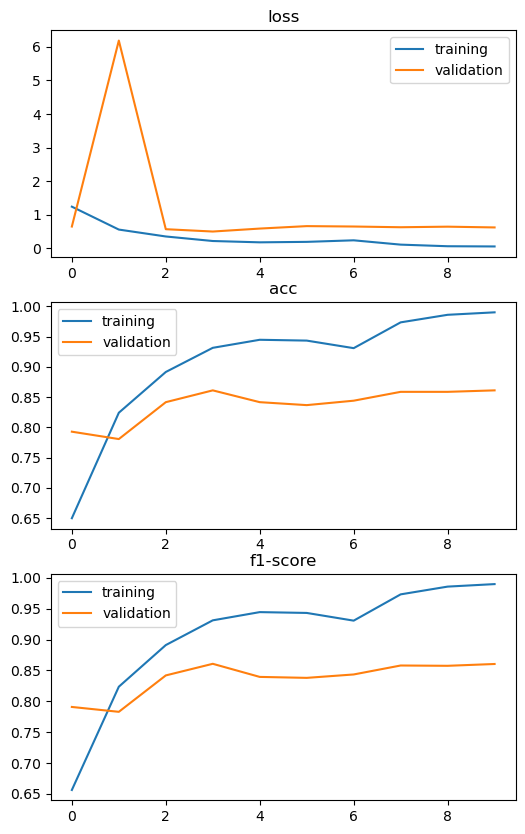

In [123]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, figsize= (6,10))
# loss
axs[0].plot(history_train['loss'], label = 'training')
axs[0].plot(history_val['loss'], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot(history_train['acc'], label = 'training')
axs[1].plot(history_val['acc'], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()
# f1-score
axs[2].plot(history_train['f1-score'], label = 'training')
axs[2].plot(history_val['f1-score'], label = 'validation')
axs[2].set_title("f1-score")
axs[2].legend()
plt.show()